In [80]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

# diffusionlab imports
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory
from investigating_diffusion_loss import AmbientDiffusionLoss

key = random.PRNGKey(0)

## Experiment: L_N difference between PMEM and Generalizing denoisers vs M/N

This notebook evaluates the L_N loss for partially memorizing (PMEM) and generalizing denoisers across different model capacities M, with a fixed t_n value.

In [114]:
# Dimension and training samples
laboratory_d = 30  # data dimension
laboratory_N = 200  # number of training samples
laboratory_K = 12  # number of components in the GMM

u_means_variance = 0.1 ** (1/2)  # order 1, controls the variance of the means of the true distribution
sample_variance = 0.1  # isotropic variance for each component

# M values: 10 values between 10 and 200
M_values = np.linspace(10, 200, 10).astype(int)
print(f"M values: {M_values}")

# Fixed t_n value
t_n_value = jnp.array(0.1)

# Time grid for evaluation
t_val_array = jnp.linspace(0.01, 0.99, 26)

# Lambda function (constant for now)
lambda_fn = lambda t: 1

M values: [ 10  31  52  73  94 115 136 157 178 200]


In [115]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Ground-truth GMM params
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])  # must sum to 1

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))

print(f"Training data shape: {X_train.shape}")
print(f"True means shape: {true_means.shape}")

Training data shape: (200, 30)
True means shape: (12, 30)


In [116]:
# Build Generalizing denoiser (same for all M values)
generalising_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

print("Generalizing model created")

Generalizing model created


C:\Users\chris\AppData\Local\Temp\ipykernel_20704\4267138444.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  generalising_model = IsoHomGMMSharedParametersEstimator(


In [117]:
def L_N(model_callable, lambda_fn, t_val_array, t_n_value, X_0_dataset, X_t_n_dataset, key):
    '''
    This function computes the L_N loss for a given model and a given lambda function.
    '''
    ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)
    standard_loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.X0, num_noise_draws_per_sample=1)

    def L_N_t_ambient(model_callable, t_n_value, t_val, X_t_n_dataset, key):
        '''
        This function computes the L_N_t for the ambient denoising term.
        '''
        assert t_val > t_n_value
        
        compute_loss = compute_loss_factory(ambient_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_n_dataset) / X_0_dataset.shape[0] 
        
        return loss_val

    def L_N_t_standard_score(model_callable, t_val, X_t_dataset, key):
        '''
        This function computes the L_N_t for the standard denoising term.
        '''
        compute_loss = compute_loss_factory(standard_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_dataset) / X_0_dataset.shape[0] 
        
        return loss_val
    
    # Split into less than t_n and greater than t_n
    less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
    greater_than_n_mask = jnp.logical_not(less_than_n_mask)

    standard_denoising_t_values = t_val_array[less_than_n_mask]
    ambient_denoising_t_values = t_val_array[greater_than_n_mask]
  
    # Compute the loss for the standard denoising term
    current_key = key
    standard_denoising_loss_values = []
    for t in standard_denoising_t_values:
        current_key, subk = random.split(current_key)
        loss_val = L_N_t_standard_score(model_callable, t, X_0_dataset, subk)
        standard_denoising_loss_values.append(lambda_fn(t) * loss_val)

    averaged_standard_denoising_loss = np.mean(standard_denoising_loss_values)

    # Compute the loss for the ambient denoising term
    ambient_denoising_loss_values = []
    for t in ambient_denoising_t_values:
        current_key, subk = random.split(current_key)
        loss_val = L_N_t_ambient(model_callable, t_n_value, t, X_t_n_dataset, subk)
        ambient_denoising_loss_values.append(lambda_fn(t) * loss_val)
    
    averaged_ambient_denoising_loss = np.mean(ambient_denoising_loss_values)

    return averaged_standard_denoising_loss + averaged_ambient_denoising_loss

In [118]:
# Generate X_t_n_dataset once (same for all M values)
key, subk = random.split(key)
X_t_n_eps = jax.random.normal(subk, X_train.shape)

batch_diffusion_forward = jax.vmap(
    diffusion_process.forward, in_axes=(0, None, 0)
)
X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)

print(f"X_t_n_dataset shape: {X_t_n_dataset.shape}")

X_t_n_dataset shape: (200, 30)


In [119]:
# Store results
pmem_losses = []
generalising_losses = []
M_over_N_values = []

# Evaluate L_N for each M value
for M in M_values:
    print(f"\nProcessing M = {M}...")
    
    # Build PMEM denoiser for this M value
    key, sk = random.split(key)
    context = {
        "X_train": X_train,
        "init_var_scale": 1e-6,
        "init_means_noise_var": 0.0,
    }
    means_pmem, var_pmem, priors_pmem = iso_hom_gmm_create_initialization_parameters(
        sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, M, context
    )
    
    pmem_model = IsoHomGMMSharedParametersEstimator(
        dim=laboratory_d,
        num_components=M,
        vf_type=VectorFieldType.X0,
        diffusion_process=diffusion_process,
        init_means=means_pmem,
        init_var=var_pmem,
        priors=priors_pmem,
    )
    
    # Evaluate L_N for PMEM model
    key, subk = random.split(key)
    pmem_loss = L_N(pmem_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset, subk)
    pmem_losses.append(float(pmem_loss))
    
    # Evaluate L_N for Generalizing model (same for all M)
    key, subk = random.split(key)
    generalising_loss = L_N(generalising_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset, subk)
    generalising_losses.append(float(generalising_loss))
    
    M_over_N = M / laboratory_N
    M_over_N_values.append(M_over_N)
    
    print(f"  M/N = {M_over_N:.4f}, PMEM loss = {pmem_loss:.6f}, Generalising loss = {generalising_loss:.6f}")

pmem_losses = np.array(pmem_losses)
generalising_losses = np.array(generalising_losses)
M_over_N_values = np.array(M_over_N_values)


Processing M = 10...


C:\Users\chris\AppData\Local\Temp\ipykernel_20704\1909845538.py:21: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  pmem_model = IsoHomGMMSharedParametersEstimator(


  M/N = 0.0500, PMEM loss = 0.057893, Generalising loss = 0.016799

Processing M = 31...
  M/N = 0.1550, PMEM loss = 0.043159, Generalising loss = 0.016748

Processing M = 52...
  M/N = 0.2600, PMEM loss = 0.036925, Generalising loss = 0.016835

Processing M = 73...
  M/N = 0.3650, PMEM loss = 0.031467, Generalising loss = 0.016746

Processing M = 94...
  M/N = 0.4700, PMEM loss = 0.027750, Generalising loss = 0.016784

Processing M = 115...
  M/N = 0.5750, PMEM loss = 0.024378, Generalising loss = 0.016690

Processing M = 136...
  M/N = 0.6800, PMEM loss = 0.021109, Generalising loss = 0.016829

Processing M = 157...
  M/N = 0.7850, PMEM loss = 0.018042, Generalising loss = 0.016677

Processing M = 178...
  M/N = 0.8900, PMEM loss = 0.015468, Generalising loss = 0.016784

Processing M = 200...
  M/N = 1.0000, PMEM loss = 0.012421, Generalising loss = 0.016672


In [120]:
# Compute the difference (PMEM - Generalising)
loss_difference = pmem_losses - generalising_losses

print("\nResults Summary:")
print(f"M values: {M_values}")
print(f"M/N values: {M_over_N_values}")
print(f"PMEM losses: {pmem_losses}")
print(f"Generalising losses: {generalising_losses}")
print(f"Difference (PMEM - Generalising): {loss_difference}")


Results Summary:
M values: [ 10  31  52  73  94 115 136 157 178 200]
M/N values: [0.05  0.155 0.26  0.365 0.47  0.575 0.68  0.785 0.89  1.   ]
PMEM losses: [0.05789319 0.04315915 0.03692474 0.03146706 0.02775038 0.02437805
 0.02110921 0.01804173 0.01546805 0.01242138]
Generalising losses: [0.01679928 0.0167484  0.01683524 0.01674565 0.01678416 0.01668967
 0.01682934 0.0166766  0.01678388 0.01667191]
Difference (PMEM - Generalising): [ 0.04109391  0.02641075  0.0200895   0.01472141  0.01096622  0.00768838
  0.00427986  0.00136513 -0.00131583 -0.00425053]


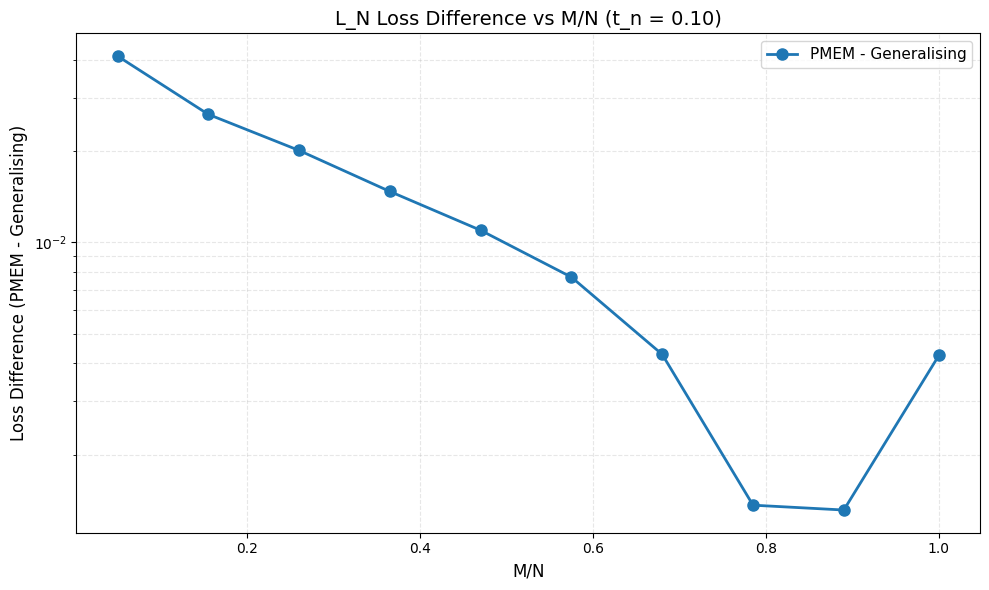

Plot saved to cross_over_plots\L_N_loss_diff_vs_M_over_N_tn_0.10.png


In [121]:
import os

# Plot the difference between PMEM and Generalising against M/N
plt.figure(figsize=(10, 6))
plt.plot(M_over_N_values, abs(loss_difference), 'o-', linewidth=2, markersize=8, label='PMEM - Generalising')
plt.xlabel('M/N', fontsize=12)
plt.ylabel('Loss Difference (PMEM - Generalising)', fontsize=12)
plt.title(f'L_N Loss Difference vs M/N (t_n = {float(t_n_value):.2f})', fontsize=14)
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(fontsize=11)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero difference')
plt.tight_layout()

# Save plot in directory "cross_over_plots", label by t_n value
output_dir = "cross_over_plots"
os.makedirs(output_dir, exist_ok=True)
plot_filename = f"L_N_loss_diff_vs_M_over_N_tn_{float(t_n_value):.2f}.png"
plot_path = os.path.join(output_dir, plot_filename)
#plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved to {plot_path}")

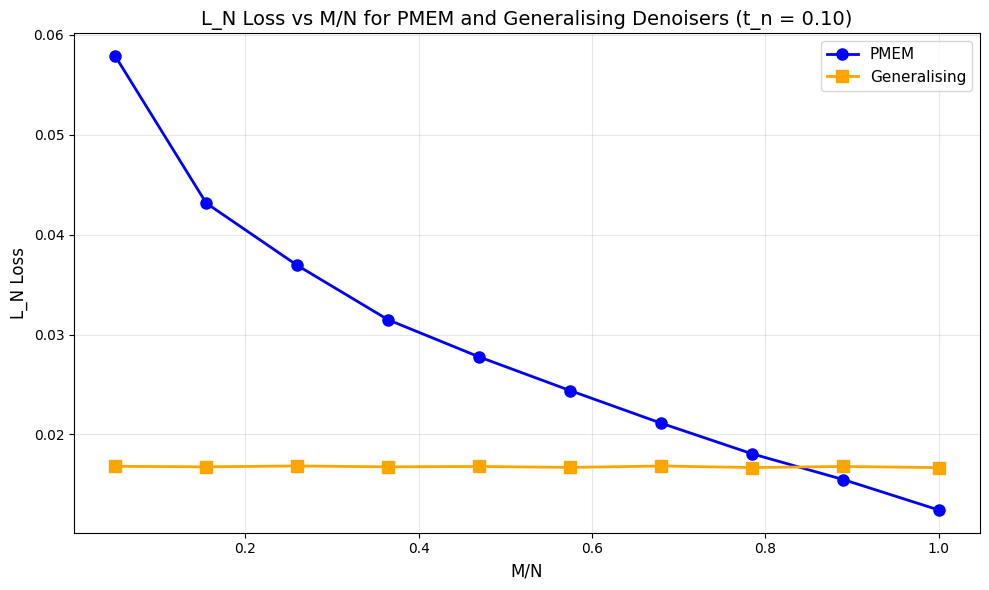

In [122]:
# Optional: Plot both losses separately for comparison
plt.figure(figsize=(10, 6))
plt.plot(M_over_N_values, pmem_losses, 'o-', linewidth=2, markersize=8, label='PMEM', color='blue')
plt.plot(M_over_N_values, generalising_losses, 's-', linewidth=2, markersize=8, label='Generalising', color='orange')
plt.xlabel('M/N', fontsize=12)
plt.ylabel('L_N Loss', fontsize=12)
plt.title(f'L_N Loss vs M/N for PMEM and Generalising Denoisers (t_n = {float(t_n_value):.2f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()